In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [6]:
d90_file = '../results/complexity_utf-16_10_10_2002_bibles_90_lcm.csv'
dall_file = '../results/complexity_utf-16_10_10_2002_bibles_lcm.csv'

# Carregar o arquivo original
original_file1 = '../dataset/bibles_lcm.csv'
original_file2 = '../dataset/bibles_90_lcm.csv'
df_original1 = pd.read_csv(original_file1)
df_original2 = pd.read_csv(original_file2)

# Calcular o tamanho do texto por língua
text_sizes_90_lcm = df_original1.groupby('language')['text'].apply(lambda x: sum(len(text) for text in x)).reset_index()
text_sizes_90_lcm = text_sizes_90_lcm.rename(columns={'text': 'text_size'})

text_sizes_lcm = df_original1.groupby('language')['text'].apply(lambda x: sum(len(text) for text in x)).reset_index()
text_sizes_lcm = text_sizes_lcm.rename(columns={'text': 'text_size'})


df90 = pd.read_csv(d90_file, index_col=False)
df90 = df90[df90.language != 'NAMBIKUÁRA'] # We removed Nambikuára because it has tone annotation
#df90.loc[df90.metric == 'del-chars', 'value'] = - df90.loc[df90.metric == 'del-chars', 'value']

dfall = pd.read_csv(dall_file, index_col=False)
dfall = dfall[dfall.language != 'NAMBIKUÁRA'] # We removed Nambikuára because it has tone annotation
#dfall.loc[dfall.metric == 'del-chars', 'value'] = - dfall.loc[dfall.metric == 'del-chars', 'value']

df90 = df90.merge(text_sizes_90_lcm, on='language', how='left')
dfall = dfall.merge(text_sizes_lcm, on='language', how='left')

family = pd.read_csv('../dataset/family.csv', index_col=None)

In [7]:
def compute(dfi, alg):
    df = dfi.copy()
    ag = df.algorithm == alg
    dw = df.metric == 'del-words'
    dc = df.metric == 'del-chars'
    
    x = df[dw & ag].groupby(['language', 'algorithm']).value.transform('mean').to_numpy()
    y = df[dc & ag].groupby(['language', 'algorithm']).value.transform('mean').to_numpy()

    df.loc[dw & ag, 'del-words'] = x
    df.loc[dw & ag, 'del-chars'] = y
    df = df.dropna().drop_duplicates('language').reset_index().drop(columns=['metric', 'index', 'run_id'])

    return df

/tmp/ipykernel_5751/28704176.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[di].scatter(
/tmp/ipykernel_5751/28704176.py:45: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[di].scatter(
/tmp/ipykernel_5751/28704176.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[di].set_xticklabels(ax[di].get_xticklabels(), fontsize=20)
/tmp/ipykernel_5751/28704176.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[di].set_yticklabels(ax[di].get_yticklabels(), fontsize=20)
/tmp/ipykernel_5751/28704176.py:45: UserWarning: Y

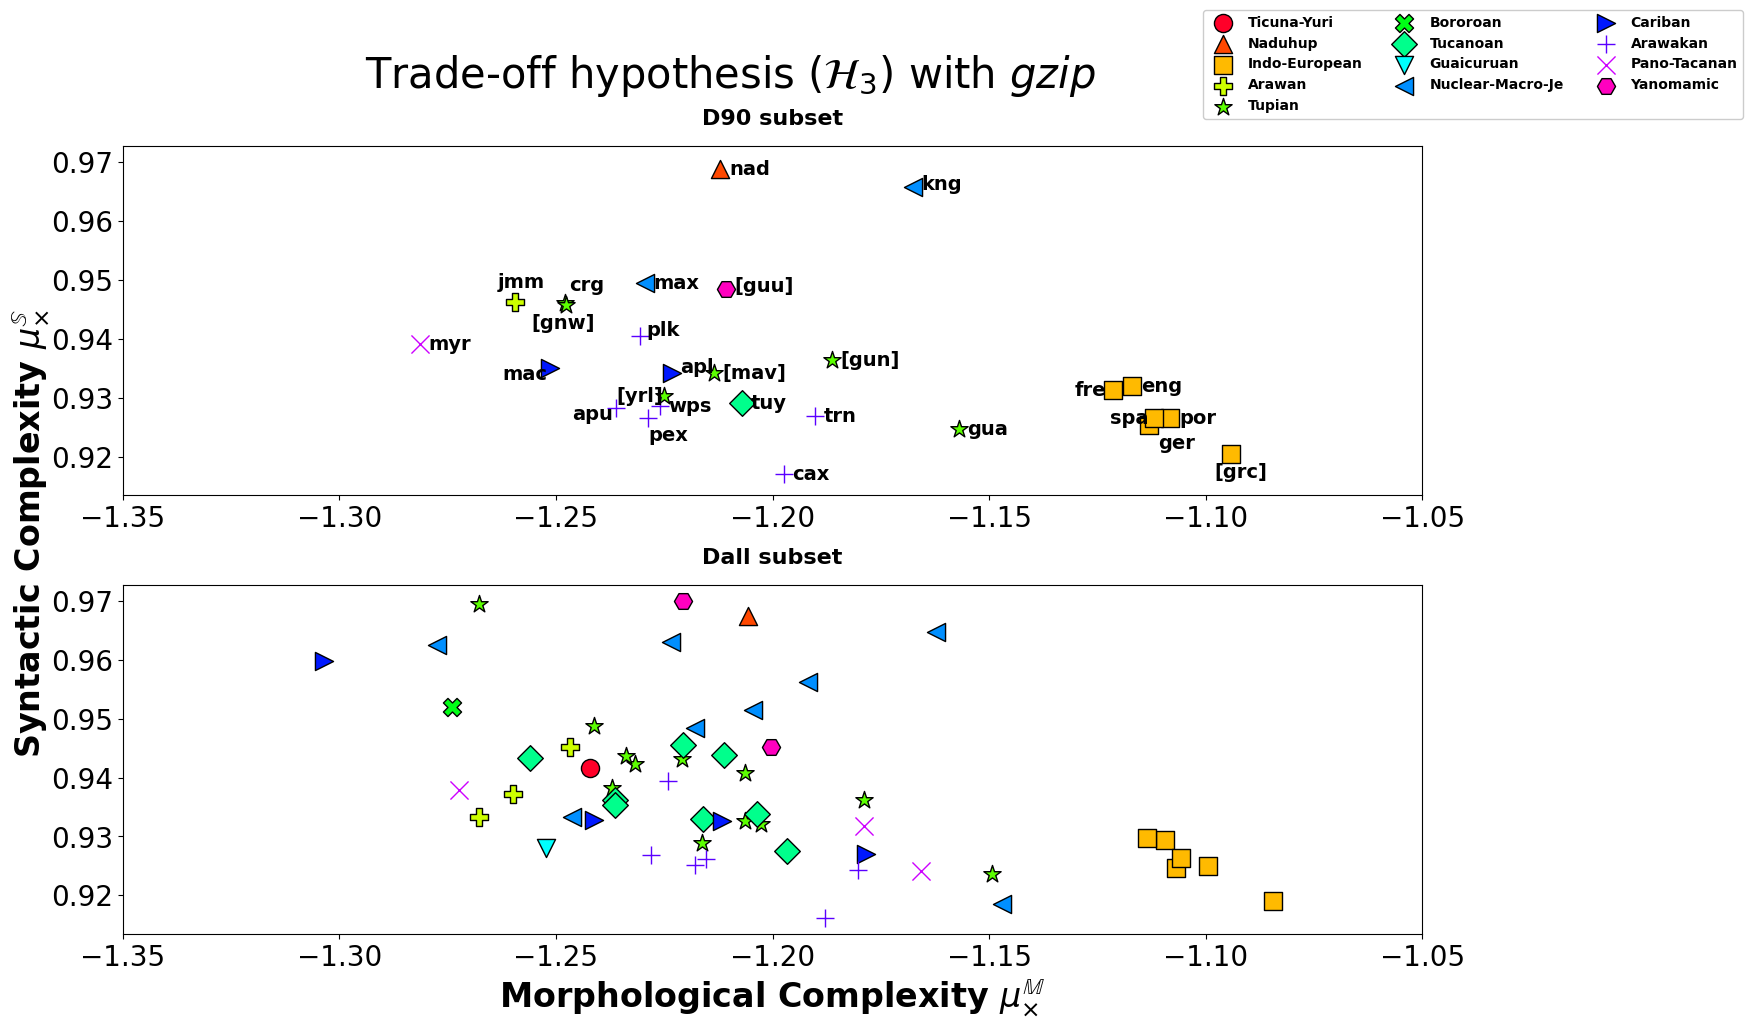

In [8]:
def plot(df90, dfall, algo, family, wals=None, text=False):

    def process_df(df, algo, wals):
        wals = wals or set(df.wals)
        df = compute(df[df.wals.isin(wals)], algo)
        df = df.merge(family[['wals', 'family_glottocode']], on='wals', how='left')
        return df

    def create_color_marker_dicts(df1, df2, families):
        unique_families = list(set(families.unique()))
        colors = plt.cm.gist_rainbow(np.linspace(0.0, 1, len(unique_families)))
        markers = ['o', '^', 's', 'P', '*', 'X', 'D', 'v', '<', '>', '+', 'x', 'H', '1', '2', '3', '4', '8', '|', '_']
        family_to_color = { f: colors[i] for i, f in enumerate(unique_families)}
        family_to_marker = { f : markers[i] for i, f in enumerate(unique_families)}
        return unique_families, (colors, family_to_color), (markers, family_to_marker)

    def set_color_marker(df, family_to_color, family_to_marker): 
        df['color'] = df['family_glottocode'].map(family_to_color)
        df['marker'] = df['family_glottocode'].map(family_to_marker)
        return df

    # process
    df90 = process_df(df90, algo, wals)
    dfall = process_df(dfall, algo, wals)

    unique_families, (colors, f2c), (markers, f2m) = create_color_marker_dicts(df90, dfall, dfall['family_glottocode'])

    df90 = set_color_marker(df90, f2c, f2m)
    dfall = set_color_marker(dfall, f2c, f2m)
    
    
    fig, ax = plt.subplots(2, 1, figsize=(15,  10), sharex=False, sharey=True)
    fig.suptitle(r"Trade-off hypothesis ($\mathcal{H}_3$) with $\it{%s}$" % (algo.lower(),), fontsize=30)
    fig.supylabel(r'Syntactic Complexity $\mu^{\mathbb{S}}_{\times}$', weight='bold', fontsize=24)
    titles = ['D90 subset', 'Dall subset']
    for di, df in enumerate([df90, dfall]):
        x = df['del-chars'].to_numpy()
        y = df['del-words'].to_numpy()
        l = df['wals'].to_numpy()
        # c = df['color'].to_numpy()
        ax[di].set_xlim((-1.35, -1.05))
        for i, f in enumerate(unique_families):
            df_family = df[df['family_glottocode'] == f]
            if len(df_family):
                ax[di].scatter(
                    df_family['del-chars'],
                    df_family['del-words'],
                    c=[colors[i]],
                    marker=markers[i],
                    edgecolor='black',
                    linewidth=1,
                    label=f if di == 1 else "",
                    s=170,
                )
        if di == 1: ax[di].set_xlabel(r'Morphological Complexity $\mu^{\mathbb{M}}_{\times}$', weight='bold', fontsize=24)
        ax[di].set_title(titles[di], fontsize=16, weight='bold', pad=15)
        
        ax[di].set_xticklabels(ax[di].get_xticklabels(), fontsize=20)
        ax[di].set_yticklabels(ax[di].get_yticklabels(), fontsize=20)
        if di == 0:
            delta = 1e-3
            rot = 0
            dec = lambda u, f: u - f*delta
            inc = lambda u, f: u + f*delta
            for xi, yi, li in zip(x, y, l):
                match li :
                    case "[gnw]":
                        xi = dec(xi, 8)
                        yi = dec(yi, 4)
                    case "crg":
                        xi = inc(xi, 1)
                        yi = inc(yi, 2)
                    case "fre":
                        xi = dec(xi, 9.0)
                        yi = dec(yi, 1.0)
                    case "spa":
                        xi = dec(xi, 10)
                        yi = dec(yi, 1)
                    case "ger":
                        xi = inc(xi, 2)
                        yi = dec(yi, 4)
                    case "[yrl]":
                        yi = dec(yi, 1)
                        xi = dec(xi, 11)
                    case "apu":
                        xi = dec(xi, 10)
                        yi = dec(yi, 2)
                    case "[grc]":
                        xi = dec(xi, 4)
                        yi = dec(yi, 4)
                    case "apl":
                        xi = inc(xi, 2)
                    case "plk":
                        xi = inc(xi, 1.5)
                    case "jmm":
                        xi = dec(xi, 4)
                        yi = inc(yi, 2.5)
                    case "pex":
                        yi = dec(yi, 4)
                        xi = inc(xi, 0)
                    case "wps":
                        yi = dec(yi, 1)
                        xi = inc(xi, 2)
                    case "[guu]":
                        xi = inc(xi, 2)
                        yi = dec(yi, 0.5)
                    case "kng":
                        xi = inc(xi, 2)
                        yi = dec(yi, 0.5)
                    case "mac":
                        xi = dec(xi, 11)
                        yi = dec(yi, 2)
                    case _:
                        xi = inc(xi, 2)
                        yi = dec(yi, 1)
                ax[di].text(xi, yi, li, rotation=rot, fontsize=14, weight='bold')
    #legend = fig.legend(title="Language Families (from Glottolog)", fontsize=20, bbox_to_anchor=(0.386, 0.3475, 0.5805, 0.5905), ncol=2, prop={'weight' : 'bold'})
    #legend = fig.legend(title="Language Families", loc='upper right', ncol=2, bbox_to_anchor=(0.97, 0.91), prop={'weight' : 'bold', 'size' : 'large'})
    legend = fig.legend(fontsize=12, bbox_to_anchor=(0.4, 0.3, 0.78, 0.730), ncol=3, prop={'weight' : 'bold'})
    legend.get_frame().set_alpha(None)
    legend.get_title().set_fontsize('x-large')
    fig.tight_layout()
    fig.savefig("../images/h3.pdf")

plot(df90, dfall, 'gzip', family=family, text=True)

/tmp/ipykernel_5751/1022456019.py:46: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[di].scatter(
/tmp/ipykernel_5751/1022456019.py:46: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax[di].scatter(
/tmp/ipykernel_5751/1022456019.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[di].set_xticklabels(ax[di].get_xticklabels(), fontsize=20)
/tmp/ipykernel_5751/1022456019.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[di].set_yticklabels(ax[di].get_yticklabels(), fontsize=20)
/tmp/ipykernel_5751/1022456019.py:46: User

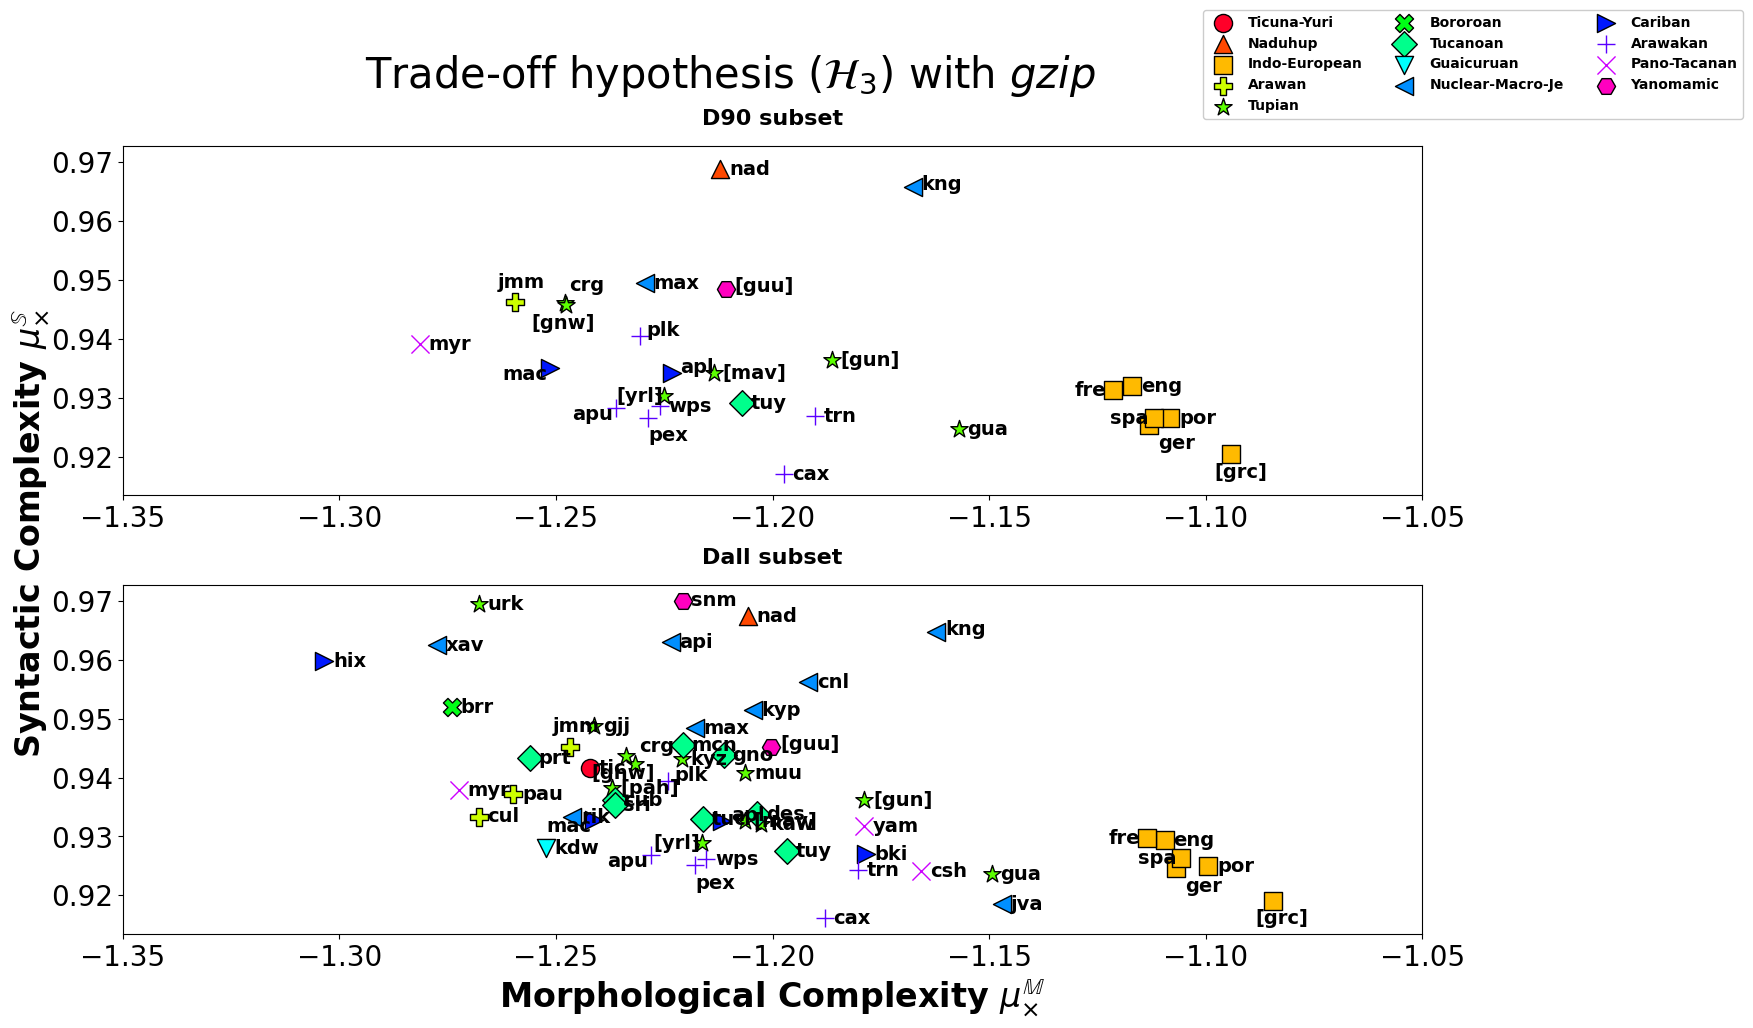

In [9]:
def plot(df90, dfall, algo, family, wals=None, text=False):

    def process_df(df, algo, wals):
        wals = wals or set(df.wals)
        df = compute(df[df.wals.isin(wals)], algo)
        df = df.merge(family[['wals', 'family_glottocode']], on='wals', how='left')
        return df

    def create_color_marker_dicts(df1, df2, families):
        unique_families = list(set(families.unique()))
        colors = plt.cm.gist_rainbow(np.linspace(0.0, 1, len(unique_families)))
        markers = ['o', '^', 's', 'P', '*', 'X', 'D', 'v', '<', '>', '+', 'x', 'H', '1', '2', '3', '4', '8', '|', '_']
        family_to_color = { f: colors[i] for i, f in enumerate(unique_families)}
        family_to_marker = { f : markers[i] for i, f in enumerate(unique_families)}
        return unique_families, (colors, family_to_color), (markers, family_to_marker)

    def set_color_marker(df, family_to_color, family_to_marker): 
        df['color'] = df['family_glottocode'].map(family_to_color)
        df['marker'] = df['family_glottocode'].map(family_to_marker)
        return df

    # process
    df90 = process_df(df90, algo, wals)
    dfall = process_df(dfall, algo, wals)

    unique_families, (colors, f2c), (markers, f2m) = create_color_marker_dicts(df90, dfall, dfall['family_glottocode'])

    df90 = set_color_marker(df90, f2c, f2m)
    dfall = set_color_marker(dfall, f2c, f2m)
    
    
    fig, ax = plt.subplots(2, 1, figsize=(15,  10), sharex=False, sharey=True)
    fig.suptitle(r"Trade-off hypothesis ($\mathcal{H}_3$) with $\it{%s}$" % (algo.lower(),), fontsize=30)
    fig.supylabel(r'Syntactic Complexity $\mu^{\mathbb{S}}_{\times}$', weight='bold', fontsize=24)
    titles = ['D90 subset', 'Dall subset']
    
    for di, df in enumerate([df90, dfall]):
        x = df['del-chars'].to_numpy()
        y = df['del-words'].to_numpy()
        l = df['wals'].to_numpy()
        ax[di].set_xlim((-1.35, -1.05))
        
        for i, f in enumerate(unique_families):
            df_family = df[df['family_glottocode'] == f]
            if len(df_family):
                ax[di].scatter(
                    df_family['del-chars'],
                    df_family['del-words'],
                    c=[colors[i]],
                    marker=markers[i],
                    edgecolor='black',
                    linewidth=1,
                    label=f if di == 1 else "",
                    s=170,
                )
        
        if di == 1: 
            ax[di].set_xlabel(r'Morphological Complexity $\mu^{\mathbb{M}}_{\times}$', weight='bold', fontsize=24)
        ax[di].set_title(titles[di], fontsize=16, weight='bold', pad=15)
        
        ax[di].set_xticklabels(ax[di].get_xticklabels(), fontsize=20)
        ax[di].set_yticklabels(ax[di].get_yticklabels(), fontsize=20)
        
        delta = 1e-3
        rot = 0
        dec = lambda u, f: u - f*delta
        inc = lambda u, f: u + f*delta
        
        for xi, yi, li in zip(x, y, l):
            match li:
                case "[gnw]":
                    xi = dec(xi, 8)
                    yi = dec(yi, 4)
                case "crg":
                    xi = inc(xi, 1)
                    yi = inc(yi, 2)
                case "fre":
                    xi = dec(xi, 9.0)
                    yi = dec(yi, 1.0)
                case "spa":
                    xi = dec(xi, 10)
                    yi = dec(yi, 1)
                case "ger":
                    xi = inc(xi, 2)
                    yi = dec(yi, 4)
                case "[yrl]":
                    yi = dec(yi, 1)
                    xi = dec(xi, 11)
                case "apu":
                    xi = dec(xi, 10)
                    yi = dec(yi, 2)
                case "[grc]":
                    xi = dec(xi, 4)
                    yi = dec(yi, 4)
                case "apl":
                    xi = inc(xi, 2)
                case "plk":
                    xi = inc(xi, 1.5)
                case "jmm":
                    xi = dec(xi, 4)
                    yi = inc(yi, 2.5)
                case "pex":
                    yi = dec(yi, 4)
                    xi = inc(xi, 0)
                case "wps":
                    yi = dec(yi, 1)
                    xi = inc(xi, 2)
                case "[guu]":
                    xi = inc(xi, 2)
                    yi = dec(yi, 0.5)
                case "kng":
                    xi = inc(xi, 2)
                    yi = dec(yi, 0.5)
                case "mac":
                    xi = dec(xi, 11)
                    yi = dec(yi, 2)
                case _:
                    xi = inc(xi, 2)
                    yi = dec(yi, 1)
            ax[di].text(xi, yi, li, rotation=rot, fontsize=14, weight='bold')

    legend = fig.legend(fontsize=12, bbox_to_anchor=(0.4, 0.3, 0.78, 0.730), ncol=3, prop={'weight' : 'bold'})
    legend.get_frame().set_alpha(None)
    legend.get_title().set_fontsize('x-large')
    fig.tight_layout()
    fig.savefig("../images/h3.pdf")

plot(df90, dfall, 'gzip', family=family, text=True)